In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

from sklearn.datasets import load_iris
from sklearn.model_selection import learning_curve, train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist

Populating the interactive namespace from numpy and matplotlib


### Load diabetes data

In [2]:
def prepare_data(filename, scaler, cv_splits=10):
    data = pd.read_csv(filename)
    print("Data types:")
    print(data.dtypes, data.shape)
    data_features, data_labels = data.drop('class', axis=1), data['class']
    data_features_train, data_features_test, data_labels_train, data_labels_test = train_test_split(data_features, 
                                                                                        data_labels, 
                                                                                        train_size=0.7, 
                                                                                        test_size=0.3,
                                                                                        stratify=data_labels,
                                                                                        random_state=42)
    data_features_train_scaled = scaler.fit_transform(data_features_train)
    data_features_test_scaled = scaler.fit_transform(data_features_test)
    print("Train data size:{},{}".format(data_features_train.shape, data_labels_train.shape))
    print("Test data size:{},{}".format(data_features_test.shape, data_labels_test.shape))
    
    print('Creating K-fold CV split..')
    k_fold = StratifiedKFold(n_splits=cv_splits, random_state=42)
    
    plt.title("Class distributions")
    plt.bar(range(len(data_labels.value_counts())), data_labels.value_counts().values.tolist())
    plt.xticks(range(len(data_labels.value_counts())), data_labels.value_counts().index.tolist())
    plt.show()
    
    return data, data_features_train_scaled, data_features_test_scaled, data_labels_train, data_labels_test, k_fold

Data types:
preg       int64
plas       int64
pres       int64
skin       int64
insu       int64
mass     float64
pedi     float64
age        int64
class     object
dtype: object (768, 9)
Train data size:(537, 8),(537,)
Test data size:(231, 8),(231,)
Creating K-fold CV split..


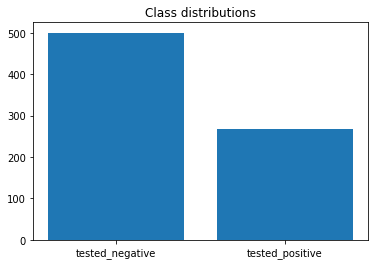

In [3]:
diabetes_data, diabetes_features_train, diabetes_features_test, diabetes_labels_train, diabetes_labels_test, k_fold = prepare_data('diabetes.csv', 
                                                                                                                           scaler=MinMaxScaler())

In [4]:
diabetes_data.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive


### GMM model

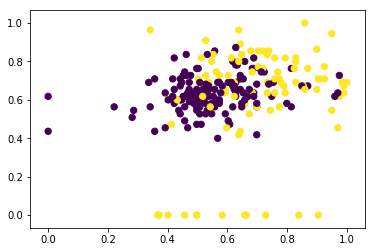

In [456]:
gmm = GaussianMixture(n_components=2, covariance_type='diag', init_params='random').fit(diabetes_features_train)
gmm_pred = gmm.predict(diabetes_features_test)
plt.scatter(diabetes_features_test[:, 1], diabetes_features_test[:, 2], c=gmm_pred, s=40, cmap='viridis');

In [457]:
def plot_confusion_matrix(labels_test, labels_pred, target_names):
    print('Confusion matrix for test data.')
    cm = confusion_matrix(labels_test, labels_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + target_names.tolist())
    ax.set_yticklabels([''] + target_names.tolist())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

#### Decode gmm predictions

In [458]:
label_encoder = LabelEncoder().fit(diabetes_labels_test.value_counts().index.tolist())
diabetes_labels_pred_enc = label_encoder.inverse_transform(gmm_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix for test data.


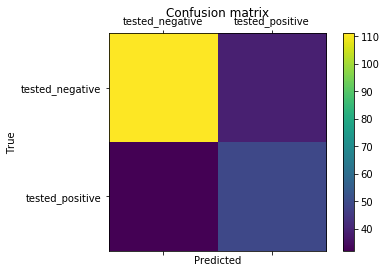

In [459]:
plot_confusion_matrix(diabetes_labels_test, diabetes_labels_pred_enc, diabetes_labels_test.value_counts().index)

In [460]:
print('Classification report for test data.')
print(classification_report(diabetes_labels_test, diabetes_labels_pred_enc, 
                            target_names=diabetes_labels_test.value_counts().index.tolist()))

Classification report for test data.
                 precision    recall  f1-score   support

tested_negative       0.78      0.74      0.76       150
tested_positive       0.56      0.60      0.58        81

    avg / total       0.70      0.69      0.70       231



In [461]:
print("GMM Accuracy: {:.3f}".format(np.mean(diabetes_labels_pred_enc == diabetes_labels_test) * 100))

GMM Accuracy: 69.264


#### Determine the best number of components based on different information criterions (Akaike or Bayesian)

Text(0.5,0,'n_components')

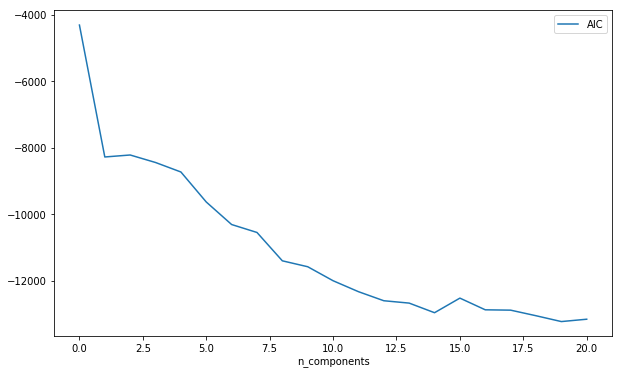

In [79]:
n_components = np.arange(2, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=42)
          for n in n_components]
aics = [model.fit(diabetes_features_train).aic(diabetes_features_train) for model in models]

plt.plot(aics, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')